# <font color=blue>A/B Testing Demo</font>
### <font color=#4D4D4D>Author: Warren Silva</font>
---

This is a sample A/B testing project. The functions defined below are intended to be highly reusable, and are designed with the flexibility to accept data sets with either a binary or a continuous target variable. The example project that follows will analyze both scenarios. The key features of this script include:


- **<font color=green>Programmatic detection of target variable variety (binary or continuous)**
- **<font color=green>Conditional execution of appropriate statistical tests based on sample size, distribution type**
- **<font color=green>Interpretation logic for accepting/rejecting the null hypothesis of group similarity</font>**


## <font color=blue>Campaign Overview and Objectives</font>
---
A retail website routinely offers the same promotion to 
first-time visitors, to drive purchase activity. They recently ran a campaign where new visitors were randomly offered a slightly different, alternative promotion. 

The campaign aims to uncover two things:
**1. Which promotion leads to a higher rate of purchase?**
**2. Among visitors who make a purchase, which group spends more?**

The scenario and company referenced below are fictitious. The data set was created using a generator, also developed by the author.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
import numpy as np
import scipy.stats as stats
import seaborn as sb
import matplotlib.pyplot as plt

# load and preview data
df = pd.read_csv('sample_data.csv')
df.head()

,id,date,group,outcome
0,aa100291,8/15/23,treatment,0.00000
1,aa101685,11/26/23,treatment,0.00000
2,aa102878,12/26/23,control,0.00000
3,aa102922,9/14/23,control,0.00000
4,aa103178,12/25/23,treatment,0.00000


## <font color=blue>Data Description</font>
---

The data set presently contains four columns:
- <code>id</code> - Unique identifier for visitor
- <code>date</code> - Date of visit
- <code>group</code> - Indicator for which promotion was offered:
    - A value of 'control' means the standard promotion was offered
    - A value of 'treatment' means the alternative promotion was offered
- <code>outcome</code> - The amount spent on the current visit

Recall that we have two questions to answer, which means we will ultimately run two seperate A/B tests. 

**1. Which promotion leads to a higher rate of purchase?**
> For this first question, we will need to create a binary indicator to distinguish purchases from non-purchases.
    
**2. Among visitors who make a purchase, which group spends more?**   
> The existing <code>outcome</code> variable will satisfy the need for this one.


In [2]:
# binary indicator for purchase
df['did_purchase'] = np.where(df['outcome'] > 0, 1, 0)

## Exploration

In [3]:
# get summary stats
def summarize(df):
    # summary dataframes
    df_type = pd.DataFrame(df.dtypes, columns=['data type'])
    df_null = pd.DataFrame(df.isnull().sum(), columns=['null_count'])
    df_null['null_pct'] = df.isnull().mean() * 100
    df_unique = pd.DataFrame(df.nunique(), columns=['unique'])
    df_stats = df.describe(include='all').transpose()
    df_stats = df_stats[['top', 'freq', 'min', 'max', 'mean', 'std']]
    
    # combine
    df_summary = pd.concat([df_type, df_null, df_unique, df_stats], axis=1)
    
    # add dup row count
    duplicate_rows = df.duplicated().sum()
    df_summary.loc['duplicate rows'] = duplicate_rows
    
    # print results
    print(f'record count: {df.shape[0]}')
    print(f'column count: {df.shape[1]}')
    print()
    print('Data Summary:')
    display(df_summary)
    
    return None

summarize(df)

record count: 100000
column count: 5

Data Summary:


,data type,null_count,null_pct,unique,top,freq,min,max,mean,std
id,object,0,0.00000,99100,or71985,3,NaN,NaN,NaN,NaN
date,object,0,0.00000,152,8/8/23,729,NaN,NaN,NaN,NaN
group,object,0,0.00000,2,treatment,51628,NaN,NaN,NaN,NaN
outcome,float64,0,0.00000,3645,NaN,NaN,0.00000,2279.77413,3.38481,23.88182
did_purchase,int64,0,0.00000,2,NaN,NaN,0.00000,1.00000,0.03644,0.18738
duplicate rows,3,3,3.00000,3,3,3,3,3,3,3


<font color=purple>Observations</font>
- Control and treatment groups are reasonably balanced with the treatment group representing a little over 51% of the data
- There are fewer unique <code>id</code> values than there are total records, indicating duplicates.
- There are also a few records where all values are duplicated.
- There is a large difference between the mean and the max outcome, suggesting we probably have some extreme outliers in our data

In [4]:
df[df['outcome']>0]['outcome'].describe()

count   3644.00000
mean      92.88711
std       85.67245
min        5.09250
25%       47.22821
50%       88.77949
75%      133.02988
max     2279.77413
Name: outcome, dtype: float64

This data contains records for the same id, representing repeat logins for the same player. Since the business problem is concerned with new players only, we will drop records for subsequent visits for the same <code>id</code> value.

In [5]:
df[df.duplicated(subset='id', keep=False)].sort_values(['id', 'date'])[0:6]

,id,date,group,outcome,did_purchase
19,aa119985,11/14/23,control,0.00000,0
18,aa119985,11/5/23,control,0.00000,0
89,aa52963,10/15/23,treatment,0.00000,0
90,aa52963,10/27/23,treatment,0.00000,0
178,ab128302,10/31/23,treatment,0.00000,0
177,ab128302,9/30/23,treatment,0.00000,0


In [6]:
# keep only first visit for each unique id
df = df.sort_values(['id', 'date'])
df = df.drop_duplicates(subset='id', keep='first').reset_index(drop=True)

In [7]:
# boxplot function
def make_boxplot(dataframe, top_val=None):
    plt.figure(figsize=(8, 12))
    ax = sb.boxplot(data=dataframe, whis=2.0)
    if top_val:
        ax.set_ylim(bottom=1, top=top_val)
    plt.show()

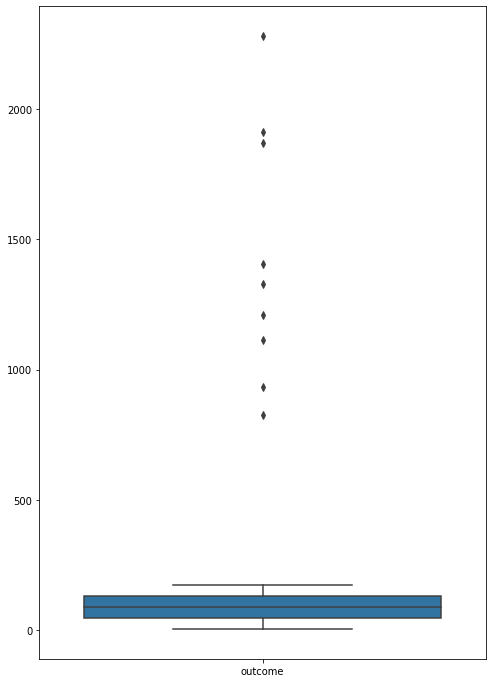

In [8]:
# focus on purchases
df_sales = df[df['outcome']>0][['outcome']]

make_boxplot(df_sales)

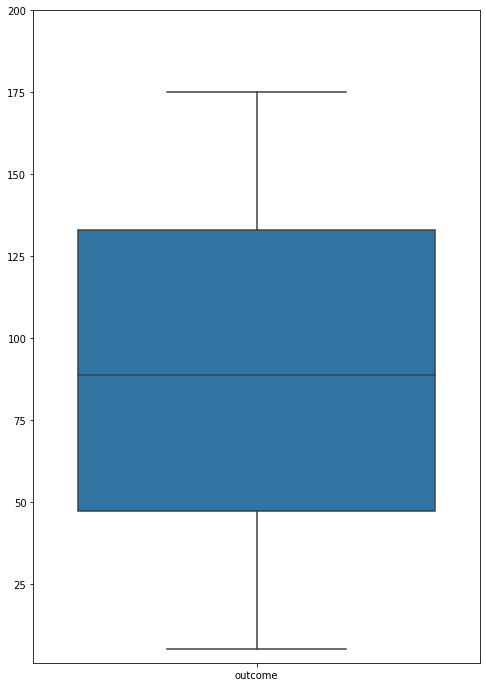

In [9]:
make_boxplot(df_sales, 200)

Rejection of 9 points
A z-score of 3 corresponds to a probability of 0.27%


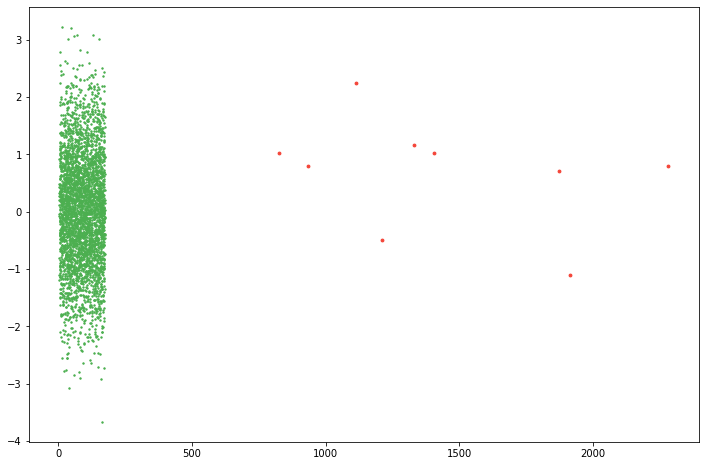

In [10]:
d1 = df_sales['outcome'].values

mean = np.mean(d1)
std = np.mean(d1)
z_score = np.abs((d1 - mean) / std)
threshold = 3
good = z_score < threshold

print(f'Rejection of {(~good).sum()} points')
print(f'A z-score of {threshold} corresponds to a probability of {100 * 2 * stats.norm.sf(threshold):0.2f}%')

visual_scatter = np.random.normal(size=d1.size)
plt.figure(figsize=(12, 8))
plt.scatter(d1[good], visual_scatter[good], s=2, label='Good', color='#4CAF50')
plt.scatter(d1[~good], visual_scatter[~good], s=8, label='Bad', color='#F44336')
plt.show()

In [11]:
# drop outliers
df = df[df['outcome'] < 500]

In [12]:
# Updated A/B testing function for binary and continuous targets
def ab_test(df_in, group, target):
    # Split A/B
    df_a = df_in[df_in[group] == 'treatment'][target]
    df_b = df_in[df_in[group] == 'control'][target]
    
    # check if the target variable is binary
    is_binary = df_in[target].nunique() == 2
    
    if is_binary:
        print('Target variable is binary') 
        
        # Create a contingency table
        contingency_table = pd.crosstab(df_in[group], df_in[target])
        
        # Decide between Chi-Square and Fisher's Exact test based on sample size
              #using Chi-Square or Fisher's Exact test.")
              
        if df_in.shape[0] >= 1000:
            print('Running Chi-Square test (sample size is >= 1000)')
            chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
            test_type = 'Chi-Square Test'
        else:
            print('Running Fisher\'s Exact test (sample size is < 1000)')
            _, p_value = stats.fisher_exact(contingency_table)
            test_type = 'Fisher\'s Exact Test'
        
        # interpret results
        ab_hypothesis = 'Reject H0' if p_value < 0.05 else 'Fail to Reject H0'
        comment = 'A/B groups are not similar!' if ab_hypothesis == 'Reject H0' else 'A/B groups are similar!'
        
        # Output DataFrame
        df_out = pd.DataFrame({
            'Test Type': [test_type],
            'AB Hypothesis': [ab_hypothesis],
            'p-value': [p_value],
            'Comment': [comment]
        })
    
    else:
        # normality test
        if (len(df_a) < 5000) & (len(df_b) < 5000):
            print('Running Shapiro-Wilk normality test (sample size is < 5000)')
            norm_a = stats.shapiro(df_a)[1] < 0.05
            norm_b = stats.shapiro(df_b)[1] < 0.05
        else:
            print('Running Kolmogorov-Smirnov normality test (sample size is > 5000)')
            norm_a = stats.kstest(df_a, 'norm')[1] < 0.05
            norm_b = stats.kstest(df_b, 'norm')[1] < 0.05

        if (norm_a == False) & (norm_b == False):  # Parametric Test
            leveneTest = stats.levene(df_a, df_b)[1] < 0.05
            if leveneTest == False:
                ttest = stats.ttest_ind(df_a, df_b, equal_var=True)[1]
            else:
                ttest = stats.ttest_ind(df_a, df_b, equal_var=False)[1]
        else:
            # Non-Parametric Test
            ttest = stats.mannwhitneyu(df_a, df_b)[1]

        # Result for continuous data
        df_out = pd.DataFrame({
            'AB Hypothesis': [ttest < 0.05],
            'p-value': [ttest]
        })
        df_out['Test Type'] = np.where((norm_a == False) & (norm_b == False), 'Parametric', 'Non-Parametric')
        df_out['AB Hypothesis'] = np.where(df_out['AB Hypothesis'] == False, 'Fail to Reject H0', 'Reject H0')
        df_out['Comment'] = np.where(df_out['AB Hypothesis'] == 'Fail to Reject H0', 'A/B groups are similar!', 'A/B groups are not similar!')

        # Additional homogeneity column for parametric tests
        if (norm_a == False) & (norm_b == False):
            df_out['Homogeneity'] = np.where(leveneTest == False, 'Yes', 'No')
            df_out = df_out[['Test Type', 'Homogeneity', 'AB Hypothesis', 'p-value', 'Comment']]
        else:
            df_out = df_out[['Test Type', 'AB Hypothesis', 'p-value', 'Comment']]
    
    return df_out

Before data cleaning
- control mean 3.54120
- treatment mean 3.23828
- p-value 0.02691

In [13]:
# run A/B test on purchase amount
ab_test(df, 'group', 'outcome')

Running Kolmogorov-Smirnov normality test (sample size is > 5000)


,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.02340,A/B groups are not similar!


In [14]:
print()
display(df.groupby('group')['outcome'].mean())

group
control     3.34886
treatment   3.17950
Name: outcome, dtype: float64

In [15]:
# run A/B test on purchase rate
ab_test(df, 'group', 'did_purchase')

Target variable is binary
Running Chi-Square test (sample size is >= 1000)


,Test Type,AB Hypothesis,p-value,Comment
0,Chi-Square Test,Reject H0,0.02273,A/B groups are not similar!


In [16]:
print()
display(df.groupby('group')['did_purchase'].mean())

group
control     0.03783
treatment   0.03510
Name: did_purchase, dtype: float64